# Kaggle competition : Nuclei instance segmentation

Romain COLLEDANI

Théo COSTES

Antoine GALLIER


In [ ]:
import os
import glob
import torch
import random
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from imgaug.augmenters import contrast as c
from imgaug.augmenters import color as iaac
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else :
  device = torch.device("cpu")
  print("cpu")



GPU


In [ ]:
## Importing  the training data set
images=list(glob(os.path.join("/content/drive/MyDrive/Kaggle FDL/train_images/*.png")))
mask= list(glob(os.path.join("/content/drive/MyDrive/Kaggle FDL/train_masks/*.png")))

images.sort()
mask.sort()

In [ ]:
# We split it : train and validation dataset
train_img = images[:2000]
val_img = images[2000:]

train_mask = mask[:2000]
val_mask = mask[2000:]

print(len(images))
print(np.asarray(train_img).shape, np.asarray(val_img).shape)
print(np.asarray(train_mask).shape, np.asarray(val_mask).shape)


2656
(2000,) (656,)
(2000,) (656,)


## Data Augmentation

We applied 2 types of augmentation :
- One more geometric (on both the images and mask),
- and one more graphic, that will change a bit the color of the image.

In [ ]:
#Geometric augmentation
def augment_data(images, masks):
    H = 256
    W = 256
    X=[]
    Y=[]
    for x, y in tqdm(zip(images, masks), total=len(images)):
        
        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        """ Augmentation """
        aug = CenterCrop(H, W, p=0.5)
        augmented = aug(image=x, mask=y)
        x1 = augmented["image"]
        y1 = augmented["mask"]

        aug = RandomRotate90(p=0.5)
        augmented = aug(image=x, mask=y)
        x2 = augmented['image']
        y2 = augmented['mask']

        aug = GridDistortion(p=0.5)
        augmented = aug(image=x, mask=y)
        x3 = augmented['image']
        y3 = augmented['mask']

        aug = HorizontalFlip(p=0.5)
        augmented = aug(image=x, mask=y)
        x4 = augmented['image']
        y4 = augmented['mask']

        aug = VerticalFlip(p=0.5)
        augmented = aug(image=x, mask=y)
        x5 = augmented['image']
        y5 = augmented['mask']

        X.append(x5)
        Y.append(y5)

    return X,Y

In [ ]:
dataex=augment_data(train_img[:2],train_mask[:2])

100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


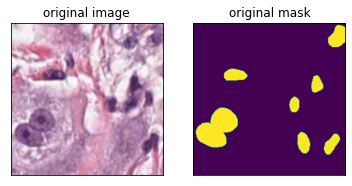

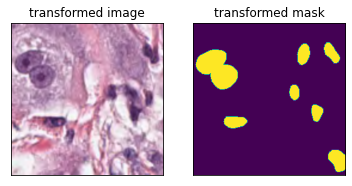

In [ ]:
display(img1,mask1,'original image', 'original mask')
display(dataex[0][0],dataex[1][0],'transformed image', 'transformed mask')

In [ ]:
dataset_train=augment_data(train_img,train_mask)
dataset_val = augment_data(val_img,val_mask)

In [ ]:
img_train=np.array(dataset_train[0])
mask_train=np.array(dataset_train[1])

img_val=np.array(dataset_val[0])
mask_val=np.array(dataset_val[1])


In [ ]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()


# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()


In [ ]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf




In [ ]:
def processing3filter(data,is_img=None):
    # ----------------------------------
    # Remove noise
    # Gaussian
    
    if is_img :
      img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data]
    else:
      img = data

    contr = c.AllChannelsCLAHE()

    dataset =[]

    original = img[0]
        


    no_noise = []
    for i in range(len(data)):
        
        
        #no_noise
        blur = cv2.GaussianBlur(img[i], (5, 5), 0)
        

        #brightness and contrast
        bright= apply_brightness_contrast(blur, -15, 40)

        dataset.append(bright)

    blur = cv2.GaussianBlur(img[0], (5, 5), 0)
    display(original,dataset[0],'original','Transformed')

    return dataset

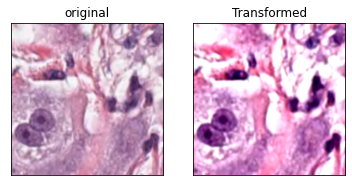

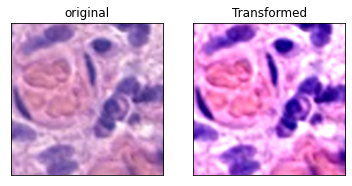

In [ ]:
process_train = processing3filter(img_train)
process_val = processing3filter(img_val)


In [ ]:
# putting images in the good format (N,3,256,256)
preprocess_img_train1 = np.transpose(process_train, (0,3,1,2))
preprocess_img_val1 = np.transpose(process_val, (0,3,1,2))


In [ ]:
from torch.utils.data.dataset import Dataset
from skimage import io
import cv2


class MyDataset(Dataset):
    def __init__(self, image_list , mask_list):
                 #, transform_img,transform_mask):

        ##Load array of images
        self.images = image_list
        self.mask = mask_list
        
    def __getitem__(self, index):
        ## Get the image-label set 
        image = self.images[index]
        #image = np.transpose(image, (0,3,1,2))
        image = image/255.0
        
        mask = self.mask[index]
        ret,thresh = cv2.threshold(mask,127,255,0)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        contour = cv2.drawContours(mask,contours,-1,(0,255,0),3)

        mask = np.reshape(mask,(1,mask.shape[0],mask.shape[1]))
        mask = np.where(mask>100,1,0)
        
        return image, mask

    def __len__(self):
        ## return the total number of data samples
        return len(self.images)

In [ ]:
train_dataset = MyDataset(preprocess_img_train1,mask_train)
val_dataset = MyDataset(preprocess_img_val1,mask_val)
                        

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader( train_dataset, batch_size=10, shuffle=True, drop_last=True)
val_dataloader = DataLoader( val_dataset, batch_size=10, shuffle=False, drop_last=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """Convolution +  BatchNorm + ReLU => 2 times"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
       
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits


In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
       
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [ ]:
# define optimizer, criterion and number of training epochs
model = UNet(n_channels = 3 , n_classes = 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = DiceBCELoss()
epochs = 60

In [ ]:
def write_results(ff, save_folder, epoch, train_loss, val_loss):
    ff=open('{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    #ff.write(' TRAIN_OA: ')
    #ff.write(str('%.3f' % train_acc))
    #ff.write(' VAL_OA: ')
    #ff.write(str('%.3f' % val_acc))
    #ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')


In [ ]:
import matplotlib.pyplot as plt
# create a function that creates train-val loss graph and saves the figure in a destination folder
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

In [ ]:
save_folder = "/content/drive/Shareddrives/Kaggle-FDL/model_new/model_geometric_tr11"

In [ ]:
from tqdm import tqdm
total_train_losses = []
total_val_losses = []

ff=open('{}/progress.txt'.format(save_folder),'w')

for epoch in range(1,epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []

    for i, batch, in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch

        img_batch= img_batch.to(device) 
        lbl_batch= lbl_batch.to(device)

        optimizer.zero_grad()
        output = model(img_batch.float())
        loss=criterion(output, lbl_batch.float())
        loss.backward()
        optimizer.step()


        train_losses.append(loss.item())

        if i % 20 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))

    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)

     ##VALIDATION##
    model.eval()
    val_losses = []

    for i, batch, in enumerate(tqdm(val_dataloader)):
        img_batch, lbl_batch = batch

        img_batch= img_batch.to(device) 
        lbl_batch= lbl_batch.to(device)

        outputs=model(img_batch.float())
        loss=criterion(outputs, lbl_batch.float())

        val_losses.append(loss.item())

    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean)
    write_results(ff, save_folder, epoch, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

save_graph(total_train_losses, total_val_losses, epochs, save_folder)

In [ ]:
test_images=list(glob(os.path.join("/content/drive/Shareddrives/Kaggle-FDL/test_images/*.png")))
test_images.sort()


In [ ]:
liste_ref_img=[]
for x in test_images:
  nom_images=x.split("/")
  nom_images=nom_images[-1]
  liste_ref_img.append(nom_images)

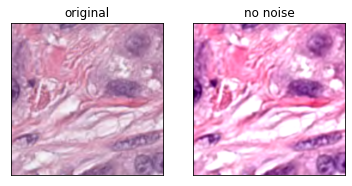

In [ ]:
preprocess_img_test = processing3filter(test_images,is_img=True)


In [ ]:
img_test = np.transpose(preprocess_img_test,  (0,3,1,2))


In [ ]:

#We select the best model
model.load_state_dict(torch.load('/content/drive/Shareddrives/Kaggle-FDL/model_new/model_geometric_tr2/model_29.pt',map_location='cpu'))
model.eval()    



In [ ]:
test_dataloader = DataLoader(img_test, batch_size=1, shuffle=False)

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    #print(pixels.shape)
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    #print(runs[1::2].shape)
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def submit(data,liste_ref_img,printed=None):
    """Used for Kaggle submission: predicts and encode all test images"""
    with open('/content/drive/Shareddrives/Kaggle-FDL/submit_file/submit5.csv', 'w') as f:
        f.write('img,rle_mask\n')
        for i, batch, in enumerate(tqdm(data)):
            img=batch
            img=img.to(device)        
            
            mask = model(img.float())
            mask = mask[0][0].detach().cpu().numpy()

            

            mask =np.where(mask >-1400 , 1 , 0)
            
            

            if printed :
              display_one(mask)
            
            else :
              enc = rle_encode(mask)
            
              f.write('{},{}\n'.format(liste_ref_img[i], enc))

In [ ]:
submit(test_dataloader,liste_ref_img,printed=True)

In [ ]:
submit(test_dataloader,liste_ref_img)